In [2]:
#pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=986995894aa640aa6ae4acf3d67d55926db0fe3847b5a05d1e56160484312cff
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [4]:
#pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 12.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import gensim
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer

# Interpret
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import shap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [90]:
#!pip uninstall seaborn -y
#!pip install seaborn==0.11.2

Found existing installation: seaborn 0.12.2
Uninstalling seaborn-0.12.2:
  Successfully uninstalled seaborn-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 15.4 MB/s eta 0:00:00


In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#df = pd.read_csv('/content/drive/MyDrive/Data/dataset_last_tp.csv', delimiter=';')

In [2]:
df = pd.read_csv('data/dataset_last_tp.csv', delimiter=';')

# EXAM
1. Exploratory Data Analsis (EDA): look closely at you data, the text, the target, any null values, any imbalance, non-numerical data to be converted?, etc.
2. Split into Training,  Validation, & Test sets (0.75, 0.1, 0.15) 
3. Clean Textual Data
4. Vectorize Texts (one hot encoder, tfidf, embeddings (word2vec with gensim, ELMO, BERT, GPT, etc.))
5. ML Classification model(s) or DL model or an ensemble of several ML/DL or both ML and DL models
6. Choose and justify the choice of the evaluation metric
7. Hyperparameter optimization (Cross validation - hyperopt - Gridsearch)
8. Evaluate on Test set
9. Use Lime to explain one text classification
10. Use Shapley to explain globally the text classification

**Comment all your steps: justify your choices, analyze the results (whether positive or negative), and finally conclude by suggesting improvements and making recommendations.**

You can use one notebook for all your work or seperate the EDA from the training and finally the testing and interpretability. <br>
You can also use .py scripts (classes/functions) and initialize/call them from the notebook. <br>

The goal is to check that you understood how does an NLP data science project starts. <br>
you will be evaluated on the methods used and **the comments and analysis** you will provide. <br>
Bad test performance will not influence your grade as long as you propose improvements and elaborate on the reasons you think might have influenced this bad results. <br>

**NB:**
Imbalance can be fixed by Over/Under sampling and Data Augmentation.<br>
Using Textual Data Augmentation techniques (libraries like textattack.augmentation, NLPAug, backtranslations, etc.,) would be a bonus if used.

I have already started the EDA section for you.
# 1. Exploratory Data Analysis

In [8]:
df.columns

Index(['medical notes', 'general_class', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9',
       ...
       'Unnamed: 100', 'Unnamed: 101', 'Unnamed: 102', 'Unnamed: 103',
       'Unnamed: 104', 'Unnamed: 105', 'Unnamed: 106', 'Unnamed: 107',
       'Unnamed: 108', 'Unnamed: 109'],
      dtype='object', length=110)

In [3]:
df = df[['medical notes', 'general_class',]]

In [4]:
df

medical notes  \
0     SUBJECTIVE:,  This 23-year-old white female pr...   
1     PAST MEDICAL HISTORY:, He has difficulty climb...   
2     HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3     2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4     1.  The left ventricular cavity size and wall ...   
...                                                 ...   
5022  HISTORY:,  I had the pleasure of meeting and e...   
5023  ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...   
5024  SUBJECTIVE: , This is a 42-year-old white fema...   
5025  CHIEF COMPLAINT: , This 5-year-old male presen...   
5026  HISTORY: , A 34-year-old male presents today s...   

                    general_class  
0            Allergy / Immunology  
1                      Bariatrics  
2                      Bariatrics  
3      Cardiovascular / Pulmonary  
4      Cardiovascular / Pulmonary  
...                           ...  
5022         Allergy / Immunology  
5023         Allergy / Immunology  
5024         Allergy / Immunology  
5025         Allergy / Immunology  
5026         Allergy / Immunology  

[5027 rows x 2 columns]

In [6]:
print("before Filtering:",len(df))
df = df[df.general_class.isin([' Surgery', ' Consult - History and Phy.',' Cardiovascular / Pulmonary', ' Orthopedic',
                               ' Radiology', ' General Medicine', ' Gastroenterology', ' Neurology',
                               ' SOAP / Chart / Progress Notes', ' Obstetrics / Gynecology',
                               ' Urology', ' Discharge Summary',
])]
print("after Filtering:",len(df))

before Filtering: 5027
after Filtering: 3861


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, ' Cardiovascular / Pulmonary'),
  Text(1, 0, ' Neurology'),
  Text(2, 0, ' Urology'),
  Text(3, 0, ' General Medicine'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' SOAP / Chart / Progress Notes'),
  Text(6, 0, ' Radiology'),
  Text(7, 0, ' Orthopedic'),
  Text(8, 0, ' Obstetrics / Gynecology'),
  Text(9, 0, ' Gastroenterology'),
  Text(10, 0, ' Discharge Summary'),
  Text(11, 0, ' Consult - History and Phy.')])

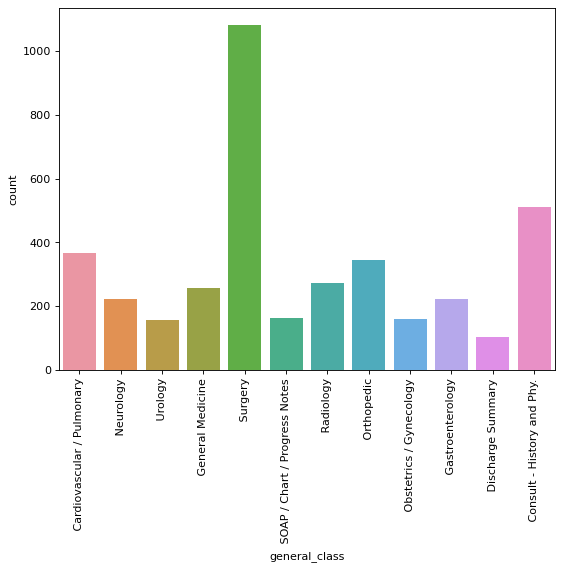

In [7]:
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(df.general_class)
plt.xticks(rotation=90)

In [8]:
# checking duplicates and nan
len(df.drop_duplicates(subset=['medical notes'], keep='first')), len(df), len(df.dropna())

(2205, 3861, 3832)

In [9]:
print("len df original:", len(df))
df.drop_duplicates(subset=['medical notes'], keep='first', inplace=True)
print('after removal of duplicates, len df:', len(df))
df.dropna(inplace=True)
print('after removal of nans, len df:', len(df))
df.reset_index(inplace=True)

len df original: 3861
after removal of duplicates, len df: 2205
after removal of nans, len df: 2204


### Classes distribution after the removal of duplicates and nans 

The distribution changed for sevaral classes like:
- Cardiovascular / Pulmonary  
- Neurology 
- ...
- Gastroenterology
- Consult - History and Phy.

However, a clear imbalanced data is the case here. <br>
To deal with it, there are several approaches:
- undersampling
- oversampling

There are several Oversampling methods in NLP:
- simple duplication of data samples
- synonyms replacement
- backtranslation
- etc.

There are several libraries to do these techniques, however, we will first start by testing undersampling.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, ' Cardiovascular / Pulmonary'),
  Text(1, 0, ' Neurology'),
  Text(2, 0, ' Urology'),
  Text(3, 0, ' General Medicine'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' SOAP / Chart / Progress Notes'),
  Text(6, 0, ' Radiology'),
  Text(7, 0, ' Orthopedic'),
  Text(8, 0, ' Obstetrics / Gynecology'),
  Text(9, 0, ' Gastroenterology'),
  Text(10, 0, ' Discharge Summary'),
  Text(11, 0, ' Consult - History and Phy.')])

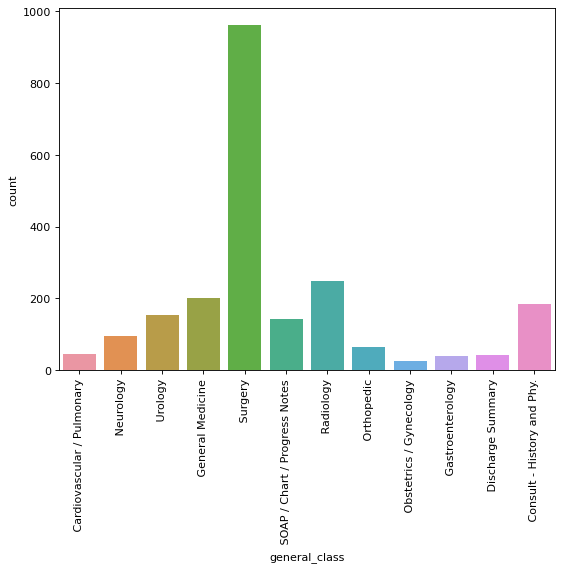

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(df.general_class)
plt.xticks(rotation=90)

In [15]:
# count observations in each class
df['general_class'].value_counts()

 Surgery                          961
 Radiology                        248
 General Medicine                 200
 Consult - History and Phy.       185
 Urology                          154
 SOAP / Chart / Progress Notes    144
 Neurology                         94
 Orthopedic                        64
 Cardiovascular / Pulmonary        44
 Discharge Summary                 43
 Gastroenterology                  41
 Obstetrics / Gynecology           26
Name: general_class, dtype: int64

### Undersampling

In [16]:
# Seperate text and target
X = df.drop(columns = 'general_class')
y = df['general_class']

In [17]:
# Calculate size of minority class
minority_class_size = min([y.value_counts()[i] for i in range(12)])
majority_class_size = y.value_counts()[0]

# Choose sampling ratio
sampling_ratio = 0.19 
# There is a huge gap between minnority class size and majority class size. So we can't undersampling all classes to the minority class size.
# Here I tried to keep 182 observationes for the classes which have more than 182 observationes.Because the average size should be around 183.
n_samples_to_keep= int(sampling_ratio * majority_class_size) # number of sample to keep which is 182.

# Undersample majority classes
undersampled_X = pd.DataFrame()
undersampled_y = pd.Series(dtype="int64")
for i in y.unique(): # loop by classes
    if y.value_counts()[i] > n_samples_to_keep: # if the class has more than 182 samples
        undersampled_X = pd.concat([undersampled_X, resample(X[y == i], n_samples=n_samples_to_keep)]).reset_index(drop=True) #randomly keep samples
        undersampled_y = pd.concat([undersampled_y, pd.Series(np.full(n_samples_to_keep, i))]).reset_index(drop=True)
    else:
        undersampled_X = pd.concat([undersampled_X, X[y == i]])
        undersampled_y = pd.concat([undersampled_y, y[y == i]])

# Shuffle data
undersampled_data = pd.concat([undersampled_X, undersampled_y], axis=1)
undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)

# Split data into X and y
X_resampled = undersampled_data.iloc[:, :-1]
y_resampled = undersampled_data.iloc[:, -1]

In [18]:
# class size after under sampling
y_resampled.value_counts()

 Consult - History and Phy.       182
 Surgery                          182
 General Medicine                 182
 Radiology                        182
 Urology                          154
 SOAP / Chart / Progress Notes    144
 Neurology                         94
 Orthopedic                        64
 Cardiovascular / Pulmonary        44
 Discharge Summary                 43
 Gastroenterology                  41
 Obstetrics / Gynecology           26
Name: 0, dtype: int64

In [19]:
print(y.shape)

(2204,)


In [20]:
# Another method, this time keep 26 samples for each class
naive_under_sample = RandomUnderSampler(sampling_strategy = 'not minority') #sampling_strategy = 'not minority','not majority','majority'
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X_under, y_under = naive_under_sample.fit_resample(X, y)
print(f"Modified set observations {X_under.shape[0]}")
print(f"Modified set target classes {len(set(y_under))}")

Initial set observations 2204
Initial set target classes 12
Modified set observations 312
Modified set target classes 12


In [21]:
# Class size after under sampling
y_under.value_counts()

 Cardiovascular / Pulmonary       26
 Consult - History and Phy.       26
 Discharge Summary                26
 Gastroenterology                 26
 General Medicine                 26
 Neurology                        26
 Obstetrics / Gynecology          26
 Orthopedic                       26
 Radiology                        26
 SOAP / Chart / Progress Notes    26
 Surgery                          26
 Urology                          26
Name: general_class, dtype: int64

We have a small dataset, so most of the data and information are lost by using under sampling. It's better to use augmentation in this case.

### Text Augmentation

In [ ]:
# Example of a Text augmentation
#from textattack.augmentation import EmbeddingAugmenter
#augmenter = EmbeddingAugmenter()
#s = 'What I cannot create, I do not understand.'
#augmenter.augment(s)
# # ['What I notable create, I do not understand.', 'What I significant create, I do not understand.', 'What I cannot engender, I do not understand.', 'What I cannot creating, I do not understand.', 'What I cannot creations, I do not understand.', 'What I cannot create, I do not comprehend.', 'What I cannot create, I do not fathom.', 'What I cannot create, I do not understanding.', 'What I cannot create, I do not understands.', 'What I cannot create, I do not understood.', 'What I cannot create, I do not realise.']

In [13]:
pip install nlpaug

In [24]:
import nlpaug.augmenter.word as naw

In [26]:
#pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.8 MB/s eta 0:00:00


In [27]:
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")

In [28]:
text = X['medical notes'][0]
augmented_text = aug.augment(text)

In [29]:
print(text)
print(augmented_text)

2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size right and left ventricle.,3.  Normal LV systolic function with left ventricular ejection fraction of 51%.,4.  Normal LV diastolic function.,5.  No pericardial effusion.,6.  Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7.  PA systolic pressure is 36 mmHg.,DOPPLER: , ,1.  Mild mitral and tricuspid regurgitation.,2.  Trace aortic and pulmonary regurgitation.
['2 - d m - mode :,, 1. left atrial enlargement with left atrial diameter of 4. 7 cubic cm., additionally 2. normal size right and left ventricle., also 3. typical normal lv systolic function but with left ventricular ejection fraction loss of 51 %., 4. normal lv diastolic function., 5. positive no pericardial effusion., 6. normal morphology of aortic valve, mitral valve, tricuspid valve, and normal pulmonary valve., 7. pa systolic pressure is 36 mmhg., doppler :,, 1. for mild mitral and stable tric

Test the method here, apply it later, because I don't want any augmented text in my validation and test set, I will just apply it on training set.

## 2. Split data into training, validation & test set

In [51]:
# At this step, we dont split X,y, because we will clean the text and encoder label in the next step.
# It's easier to keep them together for now.
train, test = train_test_split(df, test_size=0.15, random_state=42)# Split firstly train and test set.
train, val = train_test_split(train, test_size=0.1, random_state=42) # Then, split train into train and validation.

In [53]:
# Print the shapes of the sets
print("Training set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)
print("-"*50)
print("Distribution train:", train["general_class"].value_counts())
print("-"*50)
print("Distribution validation:", val["general_class"].value_counts())
print("-"*50)
print("Distribution test:", test["general_class"].value_counts())


Training set shape: (1685, 3)
Validation set shape: (188, 3)
Test set shape: (331, 3)
--------------------------------------------------
Distribution train:  Surgery                          728
 Radiology                        194
 General Medicine                 147
 Consult - History and Phy.       142
 SOAP / Chart / Progress Notes    118
 Urology                          116
 Neurology                         77
 Orthopedic                        47
 Discharge Summary                 36
 Gastroenterology                  32
 Cardiovascular / Pulmonary        27
 Obstetrics / Gynecology           21
Name: general_class, dtype: int64
--------------------------------------------------
Distribution validation:  Surgery                          83
 Radiology                        24
 General Medicine                 16
 Urology                          16
 Consult - History and Phy.       15
 SOAP / Chart / Progress Notes     6
 Orthopedic                        6
 Neurology        

In [52]:
train

index                                      medical notes  \
1324   1567  EXAM:  ,Thoracic Spine.,REASON FOR EXAM: , Inj...   
2004   4146  On review of systems, the patient admits to hy...   
948    1105  PRECATHETERIZATION DIAGNOSIS (ES):, Hypoplasti...   
2172   4704  OBSERVATIONS: , FEV1 is 3.76, 103% predicted. ...   
1296   1533  INDICATIONS:,  Chest pain.,PROCEDURE DONE:,  G...   
...     ...                                                ...   
1031   1195  PREOPERATIVE DIAGNOSIS: , Extremely large basa...   
1571   2317  HISTORY OF PRESENT ILLNESS:  ,The patient is a...   
723     833  PREOPERATIVE DIAGNOSES:,1.  Neuromuscular dysp...   
1077   1244  PREOPERATIVE DIAGNOSES:,  ,1.  Spondylosis wit...   
1653   2884  REASON FOR ADMISSION: , Hepatic encephalopathy...   

                    general_class  
1324                    Radiology  
2004   Consult - History and Phy.  
948                       Surgery  
2172   Cardiovascular / Pulmonary  
1296                    Radiology  
...                           ...  
1031                      Surgery  
1571                   Orthopedic  
723                       Surgery  
1077                      Surgery  
1653                    Neurology  

[1685 rows x 3 columns]

## 3. Text augmentation on training set

I tried to use ContextualWordEmbsAug on colab, but it's extremly time/resourse consuming, here I just use synonyme augmentation, the result may not be as well as the former one, but it's much faster.

In [54]:
# Define original data
original_data = train['medical notes'] # Your original data, e.g., list of sentences or texts
original_labels = train['general_class'] # Your original labels, e.g., list of corresponding class labels

# Get unique classes and their observation counts
unique_labels, label_counts = np.unique(original_labels, return_counts=True)

# Calculate average observation number
#avg_observation = len(original_data) // len(unique_labels)

# Perform oversampling using NLPAug
augmenter = naw.SynonymAug(aug_src='wordnet') #ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', aug_p=0.5)
augmented_data = []
augmented_labels = []
for i in train.index:
  class_label = original_labels[i]
  class_observation = label_counts[np.where(unique_labels == class_label)][0]
    
  if class_observation < 142: 
    augmented_text = augmenter.augment(original_data[i])
    augmented_data.append(augmented_text)
    augmented_labels.append(original_labels[i])

# Convert augmented data and labels to numpy arrays
augmented_data = np.array(augmented_data)
augmented_data=np.reshape(augmented_data,-1)
augmented_labels = np.array(augmented_labels)

# Concatenate original data with augmented data
X_aug = np.concatenate((original_data, augmented_data), axis=0)
y_aug = np.concatenate((original_labels, augmented_labels), axis=0)


# Print the shape of the modified dataset
print(f"Initial set observations: {original_data.shape[0]}")
print(f"Initial set target classes: {len(set(original_labels))}")
print(f"Modified set observations: {X_aug.shape[0]}")
print(f"Modified set target classes: {len(set(y_aug))}")

Initial set observations: 1685
Initial set target classes: 12
Modified set observations: 2159
Modified set target classes: 12


In [55]:
df_aug = pd.DataFrame({'medical notes': X_aug, 'general_class': y_aug})

In [56]:
df_aug

medical notes  \
0     EXAM:  ,Thoracic Spine.,REASON FOR EXAM: , Inj...   
1     On review of systems, the patient admits to hy...   
2     PRECATHETERIZATION DIAGNOSIS (ES):, Hypoplasti...   
3     OBSERVATIONS: , FEV1 is 3.76, 103% predicted. ...   
4     INDICATIONS:,  Chest pain.,PROCEDURE DONE:,  G...   
...                                                 ...   
2154  CHIEF COMPLAINT: , The patient is here for fol...   
2155  HISTORY OF PRESENT ILLNESS: , The patient is a...   
2156  CHIEF COMPLAINT: , 1. Metastatic breast cancer...   
2157  chronicle OF PRESENT ILLNESS: , The patient is...   
2158  REASON FOR ADMISSION: , Hepatic encephalopathy...   

                       general_class  
0                          Radiology  
1         Consult - History and Phy.  
2                            Surgery  
3         Cardiovascular / Pulmonary  
4                          Radiology  
...                              ...  
2154   SOAP / Chart / Progress Notes  
2155                       Neurology  
2156   SOAP / Chart / Progress Notes  
2157                      Orthopedic  
2158                       Neurology  

[2159 rows x 2 columns]

In [57]:
df_aug['general_class'].value_counts()

 Surgery                          728
 SOAP / Chart / Progress Notes    236
 Urology                          232
 Radiology                        194
 Neurology                        154
 General Medicine                 147
 Consult - History and Phy.       142
 Orthopedic                        94
 Discharge Summary                 72
 Gastroenterology                  64
 Cardiovascular / Pulmonary        54
 Obstetrics / Gynecology           42
Name: general_class, dtype: int64

In [58]:
# Count the class frequencies in the original dataset
class_frequencies = df_aug['general_class'].value_counts()

# Identify the majority class with the highest frequency
majority_class = class_frequencies.idxmax()

# Extract the instances of the majority class
majority_class_instances = df_aug[df_aug['general_class'] == majority_class]

# Undersample the majority class to match the frequency of the second biggest class
undersampled_majority_class_instances = resample(majority_class_instances,replace=False,n_samples=236,random_state=42)

# Combine the undersampled majority class instances with the minority class instances
df_train2 = pd.concat([undersampled_majority_class_instances, df_aug[df_aug['general_class']!=majority_class]])

# Shuffle the combined dataset
df_train2 = df_train2.sample(frac=1, random_state=42).reset_index(drop=True)

In [59]:
df_train2['general_class'].value_counts()

 Surgery                          236
 SOAP / Chart / Progress Notes    236
 Urology                          232
 Radiology                        194
 Neurology                        154
 General Medicine                 147
 Consult - History and Phy.       142
 Orthopedic                        94
 Discharge Summary                 72
 Gastroenterology                  64
 Cardiovascular / Pulmonary        54
 Obstetrics / Gynecology           42
Name: general_class, dtype: int64

## 4. Clean data

In [84]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [60]:
def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') # match the characters: /,(),{},[],\,@,comma(,),;
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')# match the characters which are not digits/lowercase letter/space/#/+/_
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text


def preprocessing(df):
    
       
    df['medical notes'] = [text_prepare(x) for x in df['medical notes'].values] # clean the text from 'medical notes'
    
    le = LabelEncoder()
    le.fit(df['general_class'])
    df['class_label'] = le.transform(df['general_class']) # transfer general_class to numbers
    
    tokenizer = RegexpTokenizer(r'\w+') 

    df["tokens"] = df["medical notes"].apply(tokenizer.tokenize) # tokenize the text
    
    return df

In [69]:
#test the function
train_proc = preprocessing(train)

print("count before process:",len(train_proc['medical notes'][0]))
print("count after process:",len(train_proc['tokens'][0]))

count before process: 404
count after process: 55


In [61]:
test_proc = preprocessing(test)
val_proc = preprocessing(val)
train2_proc = preprocessing(df_train2)

In [62]:
test_proc

index                                      medical notes  \
780     894  preoperative diagnosis acute appendicitisposto...   
581     659  preoperative diagnoses1 recurrent spinal steno...   
1752   3289  chief complaint jaw painhistory present illnes...   
1313   1555  nuclear cardiologycardiac stress reportindicat...   
1559   2230  admission diagnoses fracture right femoral nec...   
...     ...                                                ...   
296     334  preoperative diagnosis severe neurologic neuro...   
1075   1242  preoperative diagnosis open calcaneus fracture...   
618     714  preoperative diagnosis foreign body right foot...   
1807   3377  chief complaint nausea vomiting diarrhea fever...   
1797   3367  chief complaint dark urine generalized weaknes...   

          general_class  class_label  \
780             Surgery           10   
581             Surgery           10   
1752   General Medicine            4   
1313          Radiology            8   
1559         Orthopedic            7   
...                 ...          ...   
296             Surgery           10   
1075            Surgery           10   
618             Surgery           10   
1807   General Medicine            4   
1797   General Medicine            4   

                                                 tokens  
780   [preoperative, diagnosis, acute, appendicitisp...  
581   [preoperative, diagnoses1, recurrent, spinal, ...  
1752  [chief, complaint, jaw, painhistory, present, ...  
1313  [nuclear, cardiologycardiac, stress, reportind...  
1559  [admission, diagnoses, fracture, right, femora...  
...                                                 ...  
296   [preoperative, diagnosis, severe, neurologic, ...  
1075  [preoperative, diagnosis, open, calcaneus, fra...  
618   [preoperative, diagnosis, foreign, body, right...  
1807  [chief, complaint, nausea, vomiting, diarrhea,...  
1797  [chief, complaint, dark, urine, generalized, w...  

[331 rows x 5 columns]

## 5. Vectorize Texts

Here we use TF-IDF and Word2Vec embedding.Bert should also work well, but it will take time.

TF IDF

In [63]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vectorizer.fit(train['medical notes'])

def tfidf(df):
    list_corpus = df["medical notes"].tolist()
    list_labels = df["class_label"].tolist()

    x = tfidf_vectorizer.transform(list_corpus)
    
    return x, list_labels

Word2Vec

In [22]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

C:\Users\yin/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [23]:
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
#Inspect the model
word2vec_vocab = list(w2v_model.index_to_key)
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(set(word2vec_vocab)), len(set(word2vec_vocab_lower)))

3000000 2702150


In [24]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 300
    features = []
    for tokens in list_of_lists:
        zero_vector = np.zeros(DIMENSION)
        for w in tokens:
            if w in w2v_model:
                zero_vector += w2v_model[w]
        features.append(zero_vector/len(tokens))    
    return features

def w2v(df): 
    df = preprocessing(df)
    
    embedded_texts = embedding_feats(df.tokens)
    list_labels = df["class_label"].tolist()
    return embedded_texts, list_labels



### Baseline Model

In [25]:
# Define a function which calculates different metrics, so we can compare them.
# We got an imbalanced dataset, so here average set to weighted, 
# which will take the mean of all per-class scores while considering each class’s support.

def get_metrics(y_test, y_predicted):  

    precision = precision_score(y_test, y_predicted, average='weighted')             

    recall = recall_score(y_test, y_predicted, average='weighted')
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [64]:
# Train a baseline model to help select metric and to compare with other models
logreg = LogisticRegression(multi_class = 'multinomial')

In [71]:
df_res = pd.DataFrame(columns = ['Preprocessing', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

In [72]:
# TF-IDF approach. 1-gram
x_train_tf, y_train_tf = tfidf(train_proc)
x_val_tf,y_val_tf = tfidf(val_proc)
logreg.fit(x_train_tf, y_train_tf)
y_pred_tf = logreg.predict(x_val_tf)
accuracy, precision, recall, f1 = get_metrics(y_val_tf, y_pred_tf)
df_res = df_res.append({'Preprocessing': 'TF-IDF 1-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# TF-IDF approach. 1-gram, after augmentation
x_train_aug_tf, y_train_aug_tf = tfidf(train2_proc)
x_val_tf,y_val_tf = tfidf(val_proc)
logreg.fit(x_train_aug_tf, y_train_aug_tf)
y_pred_tf = logreg.predict(x_val_tf)
accuracy, precision, recall, f1 = get_metrics(y_val_tf, y_pred_tf)
df_res = df_res.append({'Preprocessing': 'TF-IDF 1-gram + augmentation',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# Word2vec
x_train_w2v, y_train_w2v = w2v(train)
x_val_w2v,y_val_w2v = w2v(val)
logreg.fit(x_train_w2v, y_train_w2v)
y_pred_w2v = logreg.predict(x_val_w2v)
accuracy, precision, recall, f1 = get_metrics(y_val_w2v, y_pred_w2v)
df_res = df_res.append({'Preprocessing': 'Word2vec',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)
# Word2vec + augmentation
x_train_aug_w2v, y_train_aug_w2v = w2v(df_train2)
x_val_w2v,y_val_w2v = w2v(val)
logreg.fit(x_train_aug_w2v, y_train_aug_w2v)
y_pred_w2v = logreg.predict(x_val_w2v)
accuracy, precision, recall, f1 = get_metrics(y_val_w2v, y_pred_w2v)
df_res = df_res.append({'Preprocessing': 'Word2vec + augmentation',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

In [73]:
df_res

Preprocessing Precision    Recall  F1-score  Accuracy
0                 TF-IDF 1-gram  0.685851  0.755319  0.701642  0.755319
1  TF-IDF 1-gram + augmentation  0.818546   0.81383    0.7993   0.81383
2                      Word2vec  0.617108  0.675532  0.598932  0.675532
3       Word2vec + augmentation  0.653613  0.638298  0.633468  0.638298

Accuracy is not a good choice as due to very unbalanced class maximizing it will force algorithm to predict the major one;
Precision indicates how much we can trust the algorithm when it predicts a certain class;
Recall shows how many of the true labels of the class are predicted correctly by the algorithm;
F1-score is the harmonic mean of precision and recall.

It seems that TF-IDF works better than Word2Vec with google news 300.So we will use TF-IDF vectorizor in the later models.

The data after text augmentation improve the model performance.

## 6. Over sampling using SMOTE

Here I tried to use SMOTE algorithm to realize over sampling on training set

In [74]:
from imblearn.over_sampling import SMOTE

In [75]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train_tf, y_train_tf)
print('Original dataset shape %s' % len(y_train_tf))
print('Resampled dataset shape %s' % len(y_res))

Original dataset shape 1685
Resampled dataset shape 8736


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11')])

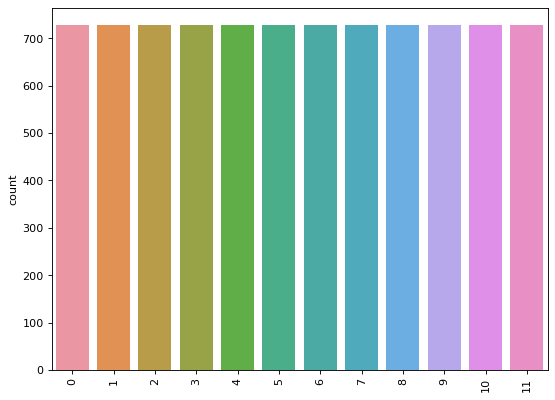

In [76]:
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(y_res)
plt.xticks(rotation=90)

After over sampling, every class has the same sample size. We will test if the over sampled data improve the model performance in the next step.

## 7. Train other models

Naive bayes

In [77]:
nbmodel = MultinomialNB()
nbmodel.fit(x_train_tf, y_train_tf)
y_pred = nbmodel.predict(x_val_tf)
    
val_f1 = f1_score(y_val_tf, y_pred, average='weighted')
print("Validation F1-score TF:", val_f1)

Validation F1-score TF: 0.3728204698635256


In [78]:
nbmodel = MultinomialNB()
nbmodel.fit(X_res, y_res)
y_pred = nbmodel.predict(x_val_tf)
    
val_f1 = f1_score(y_val_tf, y_pred, average='weighted')
print("Validation F1-score TF:", val_f1)

Validation F1-score TF: 0.7760931067559724


In [79]:
nbmodel = MultinomialNB()
nbmodel.fit(x_train_aug_tf, y_train_aug_tf)
y_pred = nbmodel.predict(x_val_tf)
    
val_f1 = f1_score(y_val_tf, y_pred, average='weighted')
print("Validation F1-score TF:", val_f1)

Validation F1-score TF: 0.6490275120140665


After over sampling and augmentation, the F1_score significantly increased for naive bayes model.

lightgbm

In [80]:
model=lgb.LGBMClassifier( 
        objective= 'multiclass',
        num_class= 12, 
         )
model.fit(x_train_tf, y_train_tf)

y_pred = model.predict(x_val_tf)
    
val_f1 = f1_score(y_val_tf, y_pred, average='weighted')
print("Validation F1-score TF:", val_f1)

Validation F1-score TF: 0.7759951857295356


In [81]:
model=lgb.LGBMClassifier( 
        objective= 'multiclass',
        num_class= 12, 
         )
model.fit(X_res, y_res)

y_pred = model.predict(x_val_tf)
    
val_f1 = f1_score(y_val_tf, y_pred, average='weighted')
print("Validation F1-score TF:", val_f1)

Validation F1-score TF: 0.8143502214613504


In [82]:
model=lgb.LGBMClassifier( 
        objective= 'multiclass',
        num_class= 12, 
         )
model.fit(x_train_aug_tf, y_train_aug_tf)

y_pred = model.predict(x_val_tf)
    
val_f1 = f1_score(y_val_tf, y_pred, average='weighted')
print("Validation F1-score TF:", val_f1)

Validation F1-score TF: 0.766700522019671


After over sampling, the F1_score increase for lightgbm model. However, text augmentation didn't improve the validation F1 score. We will test the model on test set.

## 8. Hyperparameter

In [135]:
%%time
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {'n_estimators':[100,200,300],
     'objective': ['multiclass'],
        'num_class': [12],
        'learning_rate':[0.01,0.1,1],
        'boosting': ['gbdt','dart'], 
        'metric': ['multi_logloss'],
        'max_depth': [2,4], 
        'max_bin': [10,20],
       
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1,scoring='f1_weighted')

# Fit the GridSearchCV object on the training set
grid_search.fit(x_train_tf,y_train_tf)

# Get the best parameters and best F1-score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Best Parameters: {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_bin': 10, 'max_depth': 4, 'metric': 'multi_logloss', 'n_estimators': 300, 'num_class': 12, 'objective': 'multiclass'}
Best F1-score: 0.7290528892572248
CPU times: total: 34.7 s
Wall time: 7min 10s


In [136]:
model_lgb = grid_search.best_estimator_

## 9. Test on test set

In [137]:
x_test_tf,y_test_tf = tfidf(test_proc)
model_lgb.fit(x_train_tf,y_train_tf)
y_pred_test = model_lgb.predict(x_test_tf)

test_f1 = f1_score(y_test_tf, y_pred_test,average='weighted')
print("Test F1-score:", test_f1)

Test F1-score: 0.7547108823782744


In [84]:
model_lgb.fit(X_res,y_res)
y_pred_test = model_lgb.predict(x_test_tf)

test_f1 = f1_score(y_test_tf, y_pred_test,average='weighted')
print("Test F1-score:", test_f1)

Test F1-score: 0.7443894861324185


In [85]:
model_lgb.fit(x_train_aug_tf,y_train_aug_tf)
y_pred_test = model_lgb.predict(x_test_tf)

test_f1 = f1_score(y_test_tf, y_pred_test,average='weighted')
print("Test F1-score:", test_f1)

Test F1-score: 0.7303750693467586


The added samples lead to overfitting. 

## 10. Local Model Interpretability - Lime

In [86]:
class_label= set(y_test_tf)

In [87]:
class_label

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [88]:
class_names = [' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Discharge Summary',
           ' Gastroenterology', ' General Medicine', ' Neurology', ' Obstetrics / Gynecology',
           ' Orthopedic', ' Radiology', ' SOAP / Chart / Progress Notes', ' Surgery', ' Urology']

In [89]:
lgb_pipeline = make_pipeline(tfidf_vectorizer, model_lgb)

In [90]:
lime_lgb_explainer = LimeTextExplainer(class_names=class_names)

In [102]:
lime_lgb_explainer.explain_instance(test_proc['medical notes'].loc[test_proc.index[147]],
                                    lgb_pipeline.predict_proba, labels=None,top_labels=1,num_features=10).show_in_notebook(text=True)

In [92]:
test_proc.loc[test_proc.index[147]] # Prediction is correct

index                                                          641
medical notes    preoperative diagnosis acute cholecystitispost...
general_class                                              Surgery
class_label                                                     10
tokens           [preoperative, diagnosis, acute, cholecystitis...
Name: 564, dtype: object

Lime explainer tells us that the text is predicted as 'Surgery' class because it contains words preoperative, prepped, procedure, diagnosis, direct, nylon, placed. These words are strong related to surgery, so it makes sense.

In [133]:
lime_lgb_explainer.explain_instance(test_proc['medical notes'].loc[test_proc.index[105]],
                                    lgb_pipeline.predict_proba,labels=None,top_labels=1, num_features=10).show_in_notebook(text=True)

In [134]:
test_proc.loc[test_proc.index[105]] # Prediction wrong

index                                                         4360
medical notes    history present illness patient well known his...
general_class                           Consult - History and Phy.
class_label                                                      1
tokens           [history, present, illness, patient, well, kno...
Name: 2080, dtype: object

The 105th sample is predicted as General Medicine because of the words like 'normal', 'history','multiple', 'white', 'illness'. 

The sample may be predicted as other classes because of words like 'today', 'year', 'vitamin', 'high',etc.'year' may link to 'Counlt-History and Phy', 'surgery' may link to 'Surgery'.

The model may have difficulty in distinguishing 'SOAP/Chart/Progress', 'Consult-History and Phy' and 'General Medicine'. Even though it's obvious for human to tell the difference as there are many names of medicines in the General Medicine text. But the model made wrong prediction (predict Consult - History and Phy. as General Medicine) not because of the medicine names in the text. It's also wired that the word 'vitamin' didn't make model predict 'General Medicine'.

It may because of lack of training sample, imbalanced dataset. It may be improved with more data from 'General Medicine' class and medical words pre-train embeddings. Also for text in 'Consult' and 'SOAP' class, it's important to consider the context. But the vectorizor (TF-IDF) we use here doesn't consider about the contextual meaning of the words.

In [105]:
lime_lgb_explainer.explain_instance(test_proc['medical notes'].loc[test_proc.index[200]],
                                    lgb_pipeline.predict_proba, labels=None,top_labels=1,num_features=10).show_in_notebook(text=True)

In [106]:
test_proc.loc[test_proc.index[200]] # Prediction correct.

index                                                         4562
medical notes    chief reason consultation evaluate exerciseind...
general_class                           Consult - History and Phy.
class_label                                                      1
tokens           [chief, reason, consultation, evaluate, exerci...
Name: 2136, dtype: object

The text is predicted as 'Counsult-History and Phy.' because of the words 'fine',  'consultation', 'mother', 'history','bmi', 'years', 'patient'. It may be predicted as 'General Medicine' because of words 'area', 'blood', 'wheezing'. Most of the words strong link to the predicted class, such as 'bmi', 'consultation', 'history'. But the words like 'fine', 'mother', 'years', 'patient' are quite frequent in all kings of medical notes. Though the model made the right prediction, it's hard to tell if the model predicted depending on the right words.

And the word 'blood' is more linked to 'Surgery' or other classes, but not 'Genaral Medicine'. As mentioned above, the model not predict well on 'General Medicine' class.

## 11. Explain globally the text classification using Shaply

  0%|          | 0/50 [00:00<?, ?it/s]

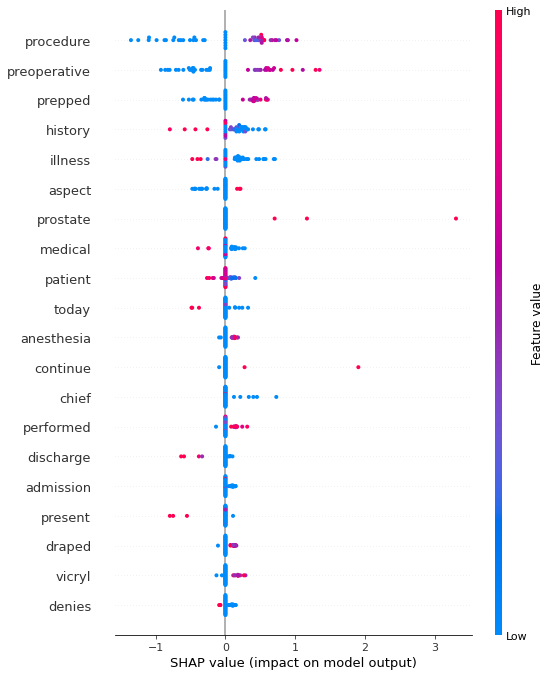

In [ ]:
# Creating a DataFrame with 50 examples from the x_test_tf and converting it to a dense format.
# Here we pick 50 samples because kernalexplainer is very time-consuming.
x_test_samp_df = pd.DataFrame(shap.sample(x_test_tf, 50).todense())

shap_lgb_explainer = shap.KernelExplainer(model_lgb.predict,
                            shap.kmeans(x_test_tf.todense(), 10))
# Calculate shaply value on samples, limit to 20 features max
shap_lgb_values_test = shap_lgb_explainer.shap_values(x_test_samp_df,
                                            l1_reg="num_features(20)") 

# Summary plot plots the shaply values(dots) and feature values (color)
shap.summary_plot(shap_lgb_values_test, x_test_samp_df,
            plot_type="dot", feature_names=tfidf_vectorizer.get_feature_names_out())

The summary plot shows the words 'procedure', 'preoperative', 'prepped' have bigger impact on model prediction. From the previous lime explainer, we can know these words are used to predict 'Surgery' class. Because of the imbalanced data, our sample (x_test_samp_df) is also imbalanced, the words used to predict the majority classes will have bigger impact on model's prediciton.

**x_test_samp_df** is randomly selected from test set, and the information from the summary plot above is quite limited. It will be better if we could take a look at how the features in every class.

## 12. Recommendations

Although we now have a model with an F1-score above 0.7, the model cannot be applied to a real situation based on the prediction explaination above. We can subsequently improve on the dataset, data processing and model selection to obtain better results.

**Data collection**: Collect more data for the minority classes.

**Text vectorize**: Test more embeddings like Bert, GPT, etc. There will might be a pre-train medical words embeddings in the future.

**Text augmentation**: Instead of synonyme replacement, try ContextualWordEmbsAug.

**Model selection**: In the notebook, I didn't try any deep learning model because of time and resourse limits. Considering the complexity of medical text, DL models may have better performance. 

